## Setup

In [ ]:
%pip freeze | grep tensorflow

tensorflow @ file:///tensorflow-2.8.0-cp37-cp37m-linux_x86_64.whl
tensorflow-datasets==4.0.1
tensorflow-estimator==2.8.0
tensorflow-gcs-config==2.8.0
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.24.0
tensorflow-metadata==1.7.0
tensorflow-probability==0.16.0


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [ ]:
def atoi(text):
  return int(text) if text.isdigit() else text

def natural_keys(text):
  '''
  alist.sort(key=natural_keys) sorts in human order
  http://nedbatchelder.com/blog/200712/human_sorting.html
  (See Toothy's implementation in the comments)
  '''
  return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## Load Case Decisions csv

In [ ]:
case_decisions_csv = '/content/drive/Shareddrives/SigmaLaw-WPP/LRR/web_scrape/criminal/decision_annotated_criminal_v1.csv'

In [ ]:
decisions_df = pd.read_csv(case_decisions_csv)
decisions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15902 entries, 0 to 15901
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15902 non-null  object
 1   decision    15902 non-null  object
 2   Y           15902 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 372.8+ KB


## Load case sentence npy files

In [ ]:
embed_folder = '/content/drive/Shareddrives/SigmaLaw-WPP/criminal_sentence_dataset/sentence_embeddings/paraphrase-distilroberta-base-v1'
sub_folders = os.listdir(embed_folder)
sub_folders.sort(key=natural_keys)

In [ ]:
case_sentence_csv_folder = '/content/drive/Shareddrives/SigmaLaw-WPP/criminal_sentence_dataset/'
csv_file_list = [
  'sentence_dataset_1000_cases.csv', 'sentence_dataset_2000_cases.csv', 'sentence_dataset_3000_cases.csv',
  'sentence_dataset_4000_cases.csv', 'sentence_dataset_5000_cases.csv', 'sentence_dataset_6000_cases.csv',
  'sentence_dataset_7000_cases.csv', 'sentence_dataset_8000_cases.csv', 'sentence_dataset_9000_cases.csv',
  'sentence_dataset_10000_cases.csv',
  'sentence_dataset_11000_cases.csv', 'sentence_dataset_12000_cases.csv',
]

In [ ]:
critical_pred_path = '/content/drive/Shareddrives/SigmaLaw-WPP/criminal_sentence_dataset/critical_sentence_prediction'

In [ ]:
seq_len = 150
vec_dim = 776
# sub_folders = sub_folders[:1]
append_critical_prob = True

In [ ]:
petitioner_lose_cases = []
petitioner_win_cases = []
for folder in tqdm(sub_folders, total=len(sub_folders)):
  npy_files = os.listdir(os.path.join(embed_folder, folder))
  npy_files.sort(key=natural_keys)

  if append_critical_prob:
    case_limit = int(folder.split('_')[1])
    sentence_df = pd.read_csv(os.path.join(case_sentence_csv_folder, f'sentence_dataset_{case_limit}_cases.csv'))
    critical_pred_df = pd.read_csv(os.path.join(critical_pred_path, f'critical_sentence_pred_results_{case_limit}.csv'))
    critical_pred_df = critical_pred_df.join(sentence_df['case_file'])
    groups = critical_pred_df.groupby('case_file')

  for fname in npy_files:
    txt_name = fname.replace('npy', 'txt')
    row_index = decisions_df.index[decisions_df['Unnamed: 0'] == txt_name].tolist()[0]
    decision_label = decisions_df.at[row_index, 'Y']
    
    fpath = os.path.join(embed_folder, folder, fname)
    with open(fpath, 'rb') as f:
      vecs = np.load(f) # (sentence_count, embed_dim)
      if append_critical_prob:
        grp = groups.get_group(txt_name)
        critical_probs = np.array(
            grp[['lose_negative', 'lose_positive', 'win_negative', 'win_positive']], dtype=np.float32)
        vecs = np.append(vecs, critical_probs, axis=1)
        dim_padding = np.zeros((vecs.shape[0], vec_dim-vecs.shape[1]), dtype=np.float32)
        vecs = np.append(vecs, dim_padding, axis=1)

    if vecs.shape[0] < seq_len:
      padding = np.zeros((seq_len - vecs.shape[0], vecs.shape[1]), dtype=np.float32)
      padded_vecs = np.append(vecs, padding, axis=0)
    else:
      padded_vecs = vecs[:seq_len, :]
    if decision_label == -1: petitioner_lose_cases.append(padded_vecs)
    elif decision_label == 1: petitioner_win_cases.append(padded_vecs)

print("\npetitioner lose cases count :", len(petitioner_lose_cases))
print("petitioner win cases count :", len(petitioner_win_cases))

100%|██████████| 12/12 [04:08<00:00, 20.70s/it]


petitioner lose cases count : 7742
petitioner win cases count : 2654


In [ ]:
import gc

In [ ]:
del sentence_df
del critical_pred_df
del groups
del grp
gc.collect()

757

In [ ]:
tot = 0
for arr in petitioner_lose_cases:
  tot += arr.nbytes/1000000

In [ ]:
tot

2960.6399999997634

In [ ]:
petitioner_lose_cases = np.array(petitioner_lose_cases, dtype=np.float32)
petitioner_win_cases = np.array(petitioner_win_cases, dtype=np.float32)

## TF Dataset

### Class balanced

In [ ]:
train_set_ratio = 0.8
val_set_ratio = 0.1

BATCH_SIZE = 32

class_len = min(len(petitioner_lose_cases), len(petitioner_win_cases))
train_set_size_per_class = int(train_set_ratio * class_len)
val_set_size_per_class = int(val_set_ratio * class_len)

In [ ]:
train_samples = petitioner_lose_cases[:train_set_size_per_class] + petitioner_win_cases[:train_set_size_per_class]

val_start = train_set_size_per_class
val_end = train_set_size_per_class + val_set_size_per_class

val_samples = petitioner_lose_cases[val_start:val_end] + petitioner_win_cases[val_start:val_end]

In [ ]:
train_labels = np.concatenate(
    (np.zeros((train_set_size_per_class), dtype=np.int32), np.ones((train_set_size_per_class), dtype=np.int32)),
    axis=0
)

val_labels = np.concatenate(
    (np.zeros((val_set_size_per_class), dtype=np.int32), np.ones((val_set_size_per_class), dtype=np.int32)),
    axis=0
)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_samples, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_samples, val_labels))

train_ds = train_ds.shuffle(train_set_size_per_class*2, seed=356).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [ ]:
for samples, labels in train_ds.take(1):
  print('samples.shape :', samples.shape)
  print('labels.shape :', labels.shape)

samples.shape : (32, 150, 768)
labels.shape : (32,)


### class imbalanced

In [ ]:
train_set_ratio = 0.8
val_set_ratio = 0.1

BATCH_SIZE = 32

In [ ]:
train_set_size_lose = int(len(petitioner_lose_cases) * train_set_ratio)
train_set_size_win = int(len(petitioner_win_cases) * train_set_ratio)

val_set_size_lose = int(len(petitioner_lose_cases) * val_set_ratio)
val_set_size_win = int(len(petitioner_win_cases) * val_set_ratio)

In [ ]:
train_samples = petitioner_lose_cases[:train_set_size_lose] + petitioner_win_cases[:train_set_size_win]

val_samples = petitioner_lose_cases[train_set_size_lose:train_set_size_lose+val_set_size_lose] +\
    petitioner_win_cases[train_set_size_win:train_set_size_win+val_set_size_win]

In [ ]:
# petitioner_win_cases[:train_set_size_win, :, :].shape

(2123, 150, 768)

In [ ]:
# train_samples = np.concatenate((
#     petitioner_lose_cases[:train_set_size_lose, :, :],
#     petitioner_win_cases[:train_set_size_win, :, :]
# ), axis=0)

# val_samples = np.concatenate((
#     petitioner_lose_cases[train_set_size_lose:train_set_size_lose+val_set_size_lose, :, :],
#     petitioner_win_cases[train_set_size_win:train_set_size_win+val_set_size_win, :, :]
# ), axis=0)

In [ ]:
import gc

In [ ]:
del petitioner_lose_cases
del petitioner_win_cases
gc.collect()

150

In [ ]:
train_labels = np.concatenate(
    (np.zeros((train_set_size_lose), dtype=np.int32), np.ones((train_set_size_win), dtype=np.int32)),
    axis=0
)

val_labels = np.concatenate(
    (np.zeros((val_set_size_lose), dtype=np.int32), np.ones((val_set_size_win), dtype=np.int32)),
    axis=0
)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_samples, train_labels))

train_ds = train_ds.shuffle(train_set_size_lose+train_set_size_win, seed=356).batch(BATCH_SIZE)

del train_samples
gc.collect()

0

In [ ]:
val_ds = tf.data.Dataset.from_tensor_slices((val_samples, val_labels))
val_ds = val_ds.batch(BATCH_SIZE)

del val_samples
gc.collect()

0

In [ ]:
for samples, labels in train_ds.take(1):
  print('samples.shape :', samples.shape)
  print('labels.shape :', labels.shape)

samples.shape : (32, 150, 776)
labels.shape : (32,)


## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the sentence in the document. 

The positional encoding vector is added to the embedding vector.

The formula for calculating the positional encoding is as follows:

$$\small{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\small{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  # print(angle_rates.shape)
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  # print(angle_rads.shape)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


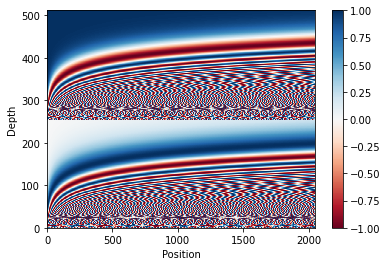

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask value for padded sentences = 1

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def mask_sentence_embedding_sequence(input_batch):
  # input_batch: tensor of shape (batch_size, seq_len, embedding_dimension)
  seq = input_batch.numpy()
  mask_list = []
  for i in range(seq.shape[0]):
    mask_list.append([])
    for j in range(seq.shape[1]):
      # print("doc:", i , "sent:", j)
      if np.count_nonzero(seq[i][j]) == 0:
        mask_list[i].append(1)
      else:
        mask_list[i].append(0)
  mask_tensor = tf.constant(mask_list, dtype=tf.float32)
  return mask_tensor[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def mask_sentence_embedding_sequence(input_batch):
  # input_batch: tensor of shape (batch_size, seq_len, embedding_dimension)
  mask = tf.cast(tf.math.count_nonzero(input_batch, axis=-1) == 0, dtype=tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([
    [[2,3,4,5], [8,3,2,3], [1,2,3,1], [1,0,0,3], [0,0,0,0]],
    [[0,4,3,6], [3,3,1,8], [9,0,4,0], [0,0,0,0], [0,0,0,0]],
], dtype=tf.float32)
print("Shape:", x.shape)
mask_sentence_embedding_sequence(x)

Shape: (2, 5, 4)


<tf.Tensor: shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1.]]],


       [[[0., 0., 0., 1., 1.]]]], dtype=float32)>

## Scaled dot product attention

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\small{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder Component

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    # x: sentence embedding sequence for the document (batch_size, num_sentences, d_model)

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62, 512), dtype=tf.float32, minval=-1, maxval=1)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## Reduction Dense Layer

In [ ]:
class ReductionDense(tf.keras.layers.Layer):
  def __init__(self, seq_len, input_units, l1_penalty_ratio=0.01):
    super(ReductionDense, self).__init__()
    self.seq_len = seq_len
    self.input_units = input_units

    self.kernal = self.add_weight(
        shape=(self.input_units,),
        initializer="glorot_uniform",
        trainable=True,
        regularizer=tf.keras.regularizers.L1(l1=l1_penalty_ratio)
    )

    self.bias = self.add_weight(
        shape=(self.seq_len,),
        initializer='zeros',
        trainable=True
    )

  def call(self, seq_input, mask=None):
    """
    seq_input: (batch_size, seq_len, d_model)
    mask: (batch_size, seq_len) | 1 for padded sentences
    """
    out = tf.math.multiply(seq_input, self.kernal)
    out = tf.reduce_sum(out, axis=-1)
    if mask is not None:
      out = out * tf.cast(tf.where(mask==1, 0, 1), dtype=out.dtype)
    out += self.bias
    return out

## Document Classification Model

In [ ]:
d_model = 768
inp_signature = [
  tf.TensorSpec(shape=(None, seq_len, d_model), dtype=tf.float32),
  tf.TensorSpec(shape=(None), dtype=tf.int32),
]

In [ ]:
class Classifier(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, pe_input, d_dense1, d_dense2=None, d_last_layer=1, rate=0.1):
    super(Classifier, self).__init__()
    self.d_dense2 = d_dense2

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, pe_input, rate)
    
    self.avg_pooling_layer = tf.keras.layers.GlobalAveragePooling1D()
    # self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dense1 = tf.keras.layers.Dense(d_dense1)
    if self.d_dense2 != None:
      # self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dense2 = tf.keras.layers.Dense(self.d_dense2)
    if d_last_layer == 1:
      self.last_layer = tf.keras.layers.Dense(d_last_layer, activation="sigmoid")
    else:
      self.last_layer = tf.keras.layers.Dense(d_last_layer, activation="softmax")

  def call(self, inp_seq, training, enc_padding_mask):
    enc_output = self.encoder(inp_seq, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    output = self.avg_pooling_layer(enc_output)
    output = self.dense1(output)
    # output = self.dropout1(output, training=training)
    if self.d_dense2 != None:
      output = self.dense2(output)
      # output = self.dropout2(output, training=training)
    final_output = self.last_layer(output)

    return final_output

  @tf.function(input_signature=inp_signature)
  def train_step(self, input_batch, label_batch):
    """
    input_batch: shape=(batch_size, seq_len, embed_dim) | dtype=tf.float32
    label_batch: shape=(batch_size) | dtype=tf.int64
    """
    enc_padding_mask = mask_sentence_embedding_sequence(input_batch)

    with tf.GradientTape() as tape:
      predictions = self(input_batch, training=True, enc_padding_mask=enc_padding_mask)

      loss = self.loss(label_batch, predictions)

    # print(loss)
    gradients = tape.gradient(loss, self.trainable_variables)
    # print(gradients)
    # print([var.name for var in tape.watched_variables()])
    # print("running optimizer...")
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    # train_accuracy.update_state(label_batch, predictions)
    return self.compute_metrics(input_batch, label_batch, predictions, sample_weight=None)

  @tf.function(input_signature=inp_signature)
  def test_step(self, input_batch, label_batch):
    enc_padding_mask = mask_sentence_embedding_sequence(input_batch)
    predictions = self(input_batch, training=False, enc_padding_mask=enc_padding_mask)
    loss = self.loss(label_batch, predictions)
    return self.compute_metrics(input_batch, label_batch, predictions, sample_weight=None)


In [ ]:
sample_classifier = Classifier(
    num_layers=2, d_model=512, num_heads=8, dff=2048, pe_input=10000,
    d_dense1=128, d_dense2=32
  )
temp_input = tf.random.uniform((32, 20, 512), dtype=tf.float32, minval=-1, maxval=1)

out = sample_classifier(temp_input, training=False, enc_padding_mask=None)
out.shape

TensorShape([32, 1])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 1
# d_model = 768
d_model = 776 if append_critical_prob else 768
dff = d_model*2
num_heads = 8
dropout_rate = 0.1
d_dense1 = 128
d_dense2 = 32
pe_input = 10000

EPOCHS = 10

## Metrics

In [ ]:
class ClassWisePrecision(tf.keras.metrics.Precision):
  def __init__(self, class_label, name=None, from_logits=False, **kwargs):
    if name == None: name = f'precision_c{class_label}'
    super(ClassWisePrecision, self).__init__(name=name, **kwargs)
    self.class_label = class_label
    self.threshold = 0.0 if from_logits else 0.5

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_label = tf.where(y_pred >= self.threshold, 1, 0)
    super().update_state(
        tf.where(y_true==self.class_label, 1, 0),
        tf.where(y_pred_label==self.class_label, 1, 0),
        sample_weight
    )

In [ ]:
class ClassWiseRecall(tf.keras.metrics.Recall):
  def __init__(self, class_label, name=None, from_logits=False, **kwargs):
    if name == None: name = f'recall_c{class_label}'
    super(ClassWiseRecall, self).__init__(name=name, **kwargs)
    self.class_label = class_label
    self.threshold = 0.0 if from_logits else 0.5

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_label = tf.where(y_pred >= self.threshold, 1, 0)
    super().update_state(
        tf.where(y_true==self.class_label, 1, 0),
        tf.where(y_pred_label==self.class_label, 1, 0),
        sample_weight
    )

## Train Sequential Model

In [ ]:
model = tf.keras.Sequential()
model.add(Encoder(num_layers, d_model, num_heads, dff, pe_input, dropout_rate))
model.add(tf.keras.layers.GlobalAveragePooling1D())
# model.add(ReductionDense(seq_len, d_model))
model.add(tf.keras.layers.Dense(d_dense1))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
additional_metrics = [
    ClassWisePrecision(class_label=0, name='lose_precision'),
    ClassWiseRecall(class_label=0, name='lose_recall'),
    ClassWisePrecision(class_label=1, name='win_precision'),
    ClassWiseRecall(class_label=1, name='win_recall')
]

In [ ]:
model.compile(
    # loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()] + additional_metrics
)

In [ ]:
model.build((None, seq_len, d_model))

In [ ]:
!rm -rf '/content/checkpoints'

In [ ]:
ckpt_folder = '/content/checkpoints'
!mkdir {ckpt_folder}

In [ ]:
checkpoint_filepath = ckpt_folder + '/ckpt-{epoch:04d}'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=0
)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/5
89/89 [==============================] - 53s 469ms/step - loss: 1.0881 - accuracy: 0.5158 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 2/5
89/89 [==============================] - 40s 445ms/step - loss: 0.7310 - accuracy: 0.5035 - val_loss: 0.7419 - val_accuracy: 0.5000
Epoch 3/5
89/89 [==============================] - 39s 438ms/step - loss: 0.7262 - accuracy: 0.5028 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 4/5
89/89 [==============================] - 39s 439ms/step - loss: 0.7252 - accuracy: 0.5197 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 5/5
89/89 [==============================] - 40s 445ms/step - loss: 0.7197 - accuracy: 0.5074 - val_loss: 0.6939 - val_accuracy: 0.5000


---
num_layers = 2

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  9454080   
                                                                 
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_38 (Dense)            multiple                  98432     
                                                                 
 dense_39 (Dense)            multiple                  129       
                                                                 
Total params: 9,552,641
Trainable params: 9,552,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/5
89/89 [==============================] - 28s 228ms/step - loss: 1.1286 - accuracy: 0.5102 - val_loss: 0.7783 - val_accuracy: 0.5000
Epoch 2/5
89/89 [==============================] - 20s 226ms/step - loss: 0.7322 - accuracy: 0.5049 - val_loss: 0.6795 - val_accuracy: 0.5787
Epoch 3/5
89/89 [==============================] - 20s 226ms/step - loss: 0.7021 - accuracy: 0.5643 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 4/5
89/89 [==============================] - 20s 224ms/step - loss: 0.6644 - accuracy: 0.6173 - val_loss: 0.6637 - val_accuracy: 0.6236
Epoch 5/5
89/89 [==============================] - 20s 224ms/step - loss: 0.6165 - accuracy: 0.6787 - val_loss: 0.6563 - val_accuracy: 0.6601


In [ ]:
model.fit(train_ds, epochs=10, initial_epoch=5, callbacks=[cp_callback], validation_data=val_ds)

Epoch 6/10
89/89 [==============================] - 20s 227ms/step - loss: 0.5364 - accuracy: 0.7321 - val_loss: 0.6518 - val_accuracy: 0.6657
Epoch 7/10
89/89 [==============================] - 20s 225ms/step - loss: 0.5362 - accuracy: 0.7405 - val_loss: 0.7587 - val_accuracy: 0.5871
Epoch 8/10
89/89 [==============================] - 20s 228ms/step - loss: 0.5021 - accuracy: 0.7690 - val_loss: 0.7909 - val_accuracy: 0.5955
Epoch 9/10
89/89 [==============================] - 20s 226ms/step - loss: 0.4752 - accuracy: 0.7844 - val_loss: 0.7453 - val_accuracy: 0.6096
Epoch 10/10
89/89 [==============================] - 20s 227ms/step - loss: 0.4659 - accuracy: 0.7862 - val_loss: 0.7842 - val_accuracy: 0.6320


In [ ]:
model.fit(train_ds, epochs=15, initial_epoch=10, callbacks=[cp_callback], validation_data=val_ds)

Epoch 11/15
89/89 [==============================] - 21s 232ms/step - loss: 0.4370 - accuracy: 0.7992 - val_loss: 0.7486 - val_accuracy: 0.6433
Epoch 12/15
89/89 [==============================] - 20s 227ms/step - loss: 0.4114 - accuracy: 0.8150 - val_loss: 0.8016 - val_accuracy: 0.6236
Epoch 13/15
89/89 [==============================] - 20s 225ms/step - loss: 0.4306 - accuracy: 0.8044 - val_loss: 0.8068 - val_accuracy: 0.6152
Epoch 14/15
89/89 [==============================] - 20s 220ms/step - loss: 0.4501 - accuracy: 0.7978 - val_loss: 0.7943 - val_accuracy: 0.6292
Epoch 15/15
89/89 [==============================] - 20s 223ms/step - loss: 0.4330 - accuracy: 0.8076 - val_loss: 0.8373 - val_accuracy: 0.5702


---
num_layers = 1

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  4727040   
                                                                 
 global_average_pooling1d_3   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_54 (Dense)            multiple                  98432     
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
 dense_55 (Dense)            multiple                  129       
                                                                 
Total params: 4,825,601
Trainable params: 4,825,601
Non-trainable params: 0
___________________________________________

In [ ]:
model.fit(train_ds, epochs=EPOCHS, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/20
89/89 [==============================] - 15s 127ms/step - loss: 0.7489 - accuracy: 0.5646 - val_loss: 0.6349 - val_accuracy: 0.6404
Epoch 2/20
89/89 [==============================] - 11s 125ms/step - loss: 0.6177 - accuracy: 0.6654 - val_loss: 0.6442 - val_accuracy: 0.6545
Epoch 3/20
89/89 [==============================] - 11s 124ms/step - loss: 0.5320 - accuracy: 0.7317 - val_loss: 0.6519 - val_accuracy: 0.6938
Epoch 4/20
89/89 [==============================] - 11s 118ms/step - loss: 0.4463 - accuracy: 0.7921 - val_loss: 0.9370 - val_accuracy: 0.6067
Epoch 5/20
89/89 [==============================] - 11s 119ms/step - loss: 0.3597 - accuracy: 0.8364 - val_loss: 0.8496 - val_accuracy: 0.6742
Epoch 6/20
89/89 [==============================] - 11s 122ms/step - loss: 0.2675 - accuracy: 0.8866 - val_loss: 0.9810 - val_accuracy: 0.6770
Epoch 7/20
89/89 [==============================] - 11s 120ms/step - loss: 0.2405 - accuracy: 0.9027 - val_loss: 1.1236 - val_accuracy: 0.6573

---
dataset upto case_12000 csv

In [ ]:
model.fit(train_ds, epochs=EPOCHS, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/10
133/133 [==============================] - 30s 196ms/step - loss: 1.0204 - binary_accuracy: 0.5285 - lose_precision: 0.5284 - lose_recall: 0.5304 - win_precision: 0.5286 - win_recall: 0.5266 - val_loss: 0.8028 - val_binary_accuracy: 0.5019 - val_lose_precision: 0.5009 - val_lose_recall: 1.0000 - val_win_precision: 1.0000 - val_win_recall: 0.0038
Epoch 2/10
133/133 [==============================] - 26s 190ms/step - loss: 0.7403 - binary_accuracy: 0.5516 - lose_precision: 0.5513 - lose_recall: 0.5544 - win_precision: 0.5519 - win_recall: 0.5488 - val_loss: 0.7036 - val_binary_accuracy: 0.5509 - val_lose_precision: 0.6116 - val_lose_recall: 0.2792 - val_win_precision: 0.5330 - val_win_recall: 0.8226
Epoch 3/10
133/133 [==============================] - 25s 190ms/step - loss: 0.6900 - binary_accuracy: 0.6152 - lose_precision: 0.6154 - lose_recall: 0.6142 - win_precision: 0.6150 - win_recall: 0.6161 - val_loss: 0.6330 - val_binary_accuracy: 0.6283 - val_lose_precision: 0.6417 - 

---
focal loss
case 12000

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4727040   
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             multiple                  98432     
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  129       
                                                                 
Total params: 4,825,601
Trainable params: 4,825,601
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(train_ds, epochs=EPOCHS, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/10
260/260 [==============================] - 40s 126ms/step - loss: 0.3074 - binary_accuracy: 0.6560 - lose_precision: 0.7540 - lose_recall: 0.7986 - win_precision: 0.2899 - win_recall: 0.2398 - val_loss: 0.1626 - val_binary_accuracy: 0.6497 - val_lose_precision: 0.7945 - val_lose_recall: 0.7145 - val_win_precision: 0.3557 - val_win_recall: 0.4604
Epoch 2/10
260/260 [==============================] - 31s 121ms/step - loss: 0.1635 - binary_accuracy: 0.6953 - lose_precision: 0.7585 - lose_recall: 0.8668 - win_precision: 0.3341 - win_recall: 0.1950 - val_loss: 0.1476 - val_binary_accuracy: 0.7122 - val_lose_precision: 0.7995 - val_lose_recall: 0.8191 - val_win_precision: 0.4309 - val_win_recall: 0.4000
Epoch 3/10
260/260 [==============================] - 31s 119ms/step - loss: 0.1472 - binary_accuracy: 0.7221 - lose_precision: 0.7700 - lose_recall: 0.8939 - win_precision: 0.4165 - win_recall: 0.2209 - val_loss: 0.1497 - val_binary_accuracy: 0.7449 - val_lose_precision: 0.7449 - 

In [ ]:
model.fit(train_ds, epochs=EPOCHS+10, initial_epoch=10, callbacks=[cp_callback], validation_data=val_ds)

Epoch 11/20
260/260 [==============================] - 31s 118ms/step - loss: 0.1068 - binary_accuracy: 0.8040 - lose_precision: 0.8359 - lose_recall: 0.9168 - win_precision: 0.6619 - win_recall: 0.4748 - val_loss: 0.1676 - val_binary_accuracy: 0.6102 - val_lose_precision: 0.8758 - val_lose_recall: 0.5556 - val_win_precision: 0.3723 - val_win_recall: 0.7698
Epoch 12/20
260/260 [==============================] - 31s 117ms/step - loss: 0.1042 - binary_accuracy: 0.8092 - lose_precision: 0.8459 - lose_recall: 0.9094 - win_precision: 0.6616 - win_recall: 0.5167 - val_loss: 0.1399 - val_binary_accuracy: 0.7161 - val_lose_precision: 0.7975 - val_lose_recall: 0.8295 - val_win_precision: 0.4359 - val_win_recall: 0.3849
Epoch 13/20
260/260 [==============================] - 31s 118ms/step - loss: 0.1040 - binary_accuracy: 0.8153 - lose_precision: 0.8450 - lose_recall: 0.9209 - win_precision: 0.6873 - win_recall: 0.5073 - val_loss: 0.1397 - val_binary_accuracy: 0.7469 - val_lose_precision: 0.7894

---
learning rate scheduler: CosineDecayWithStableRange

In [ ]:
import math

class CosineDecayWithStableRange(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, start_lr, end_lr, decay_start_step, total_steps, pi=math.pi) -> None:
    super(CosineDecayWithStableRange, self).__init__()
    self.start_lr = tf.constant(start_lr, dtype=tf.float32)
    self.end_lr = tf.constant(end_lr, dtype=tf.float32)
    self.decay_start_step = tf.constant(decay_start_step, dtype=tf.float32)
    self.total_steps = tf.constant(total_steps, dtype=tf.float32)
    self.decay_steps = self.total_steps - self.decay_start_step
    self.pi = tf.constant(pi, dtype=tf.float32)

  def __call__(self, step):
    arg = tf.math.maximum(step, self.decay_start_step) - self.decay_start_step
    return self.start_lr - (self.start_lr - self.end_lr) * tf.math.sin((self.pi / 2) * (arg / self.decay_steps))


In [ ]:
model.compile(
    # loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
    optimizer=tf.keras.optimizers.Adam(
        CosineDecayWithStableRange(0.001, 0.0001, decay_start_step=260*2, total_steps=260*20)
    ),
    metrics=[tf.keras.metrics.BinaryAccuracy()] + additional_metrics
)

In [ ]:
model.fit(train_ds, epochs=20, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/20
260/260 [==============================] - 36s 126ms/step - loss: 0.3920 - binary_accuracy: 0.6585 - lose_precision: 0.7524 - lose_recall: 0.8070 - win_precision: 0.2857 - win_recall: 0.2252 - val_loss: 0.1417 - val_binary_accuracy: 0.7459 - val_lose_precision: 0.7481 - val_lose_recall: 0.9935 - val_win_precision: 0.5455 - val_win_recall: 0.0226
Epoch 2/20
260/260 [==============================] - 32s 122ms/step - loss: 0.1675 - binary_accuracy: 0.6904 - lose_precision: 0.7543 - lose_recall: 0.8665 - win_precision: 0.3120 - win_recall: 0.1766 - val_loss: 0.1502 - val_binary_accuracy: 0.7449 - val_lose_precision: 0.7449 - val_lose_recall: 1.0000 - val_win_precision: 0.0000e+00 - val_win_recall: 0.0000e+00
Epoch 3/20
260/260 [==============================] - 32s 122ms/step - loss: 0.1499 - binary_accuracy: 0.7174 - lose_precision: 0.7609 - lose_recall: 0.9049 - win_precision: 0.3807 - win_recall: 0.1705 - val_loss: 0.1537 - val_binary_accuracy: 0.6612 - val_lose_precision: 0

## Train model (with critical probs)

focal loss + cases 12000 + fixed lr

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4825944   
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             multiple                  99456     
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  129       
                                                                 
Total params: 4,925,529
Trainable params: 4,925,529
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(train_ds, epochs=20, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/20
260/260 [==============================] - 41s 129ms/step - loss: 0.3276 - binary_accuracy: 0.6538 - lose_precision: 0.7528 - lose_recall: 0.7967 - win_precision: 0.2855 - win_recall: 0.2369 - val_loss: 0.1408 - val_binary_accuracy: 0.7449 - val_lose_precision: 0.7449 - val_lose_recall: 1.0000 - val_win_precision: 0.0000e+00 - val_win_recall: 0.0000e+00
Epoch 2/20
260/260 [==============================] - 33s 126ms/step - loss: 0.1674 - binary_accuracy: 0.6890 - lose_precision: 0.7605 - lose_recall: 0.8502 - win_precision: 0.3338 - win_recall: 0.2190 - val_loss: 0.1524 - val_binary_accuracy: 0.7103 - val_lose_precision: 0.8124 - val_lose_recall: 0.7946 - val_win_precision: 0.4362 - val_win_recall: 0.4642
Epoch 3/20
260/260 [==============================] - 33s 127ms/step - loss: 0.1488 - binary_accuracy: 0.7223 - lose_precision: 0.7700 - lose_recall: 0.8942 - win_precision: 0.4173 - win_recall: 0.2209 - val_loss: 0.1378 - val_binary_accuracy: 0.7469 - val_lose_precision: 0

focal loss + cases 12000 + CosineDecayWithStableRange lr

In [ ]:
model.compile(
    # loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),
    optimizer=tf.keras.optimizers.Adam(
        CosineDecayWithStableRange(0.001, 0.0001, decay_start_step=260*5, total_steps=260*30)
    ),
    metrics=[tf.keras.metrics.BinaryAccuracy()] + additional_metrics
)

In [ ]:
model.build((None, seq_len, d_model))

In [ ]:
model.fit(train_ds, epochs=30, initial_epoch=0, callbacks=[cp_callback], validation_data=val_ds)

Epoch 1/30
260/260 [==============================] - 26s 73ms/step - loss: 0.2952 - binary_accuracy: 0.6514 - lose_precision: 0.7505 - lose_recall: 0.7969 - win_precision: 0.2770 - win_recall: 0.2270 - val_loss: 0.1442 - val_binary_accuracy: 0.7421 - val_lose_precision: 0.7525 - val_lose_recall: 0.9742 - val_win_precision: 0.4595 - val_win_recall: 0.0642
Epoch 2/30
260/260 [==============================] - 18s 69ms/step - loss: 0.1647 - binary_accuracy: 0.6929 - lose_precision: 0.7576 - lose_recall: 0.8640 - win_precision: 0.3280 - win_recall: 0.1936 - val_loss: 0.1568 - val_binary_accuracy: 0.6949 - val_lose_precision: 0.8059 - val_lose_recall: 0.7778 - val_win_precision: 0.4110 - val_win_recall: 0.4528
Epoch 3/30
260/260 [==============================] - 18s 68ms/step - loss: 0.1501 - binary_accuracy: 0.7177 - lose_precision: 0.7663 - lose_recall: 0.8933 - win_precision: 0.3974 - win_recall: 0.2054 - val_loss: 0.1496 - val_binary_accuracy: 0.7449 - val_lose_precision: 0.7449 - val

## Optimizer & Loss Function

In [ ]:
class WarmupAndDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
  """
  Learning rate scheduler described in paper, Attention Is All You Need [arxiv: 1706.03762]
  """
  def __init__(self, d_model, warmup_steps=4000):
    super(WarmupAndDecay, self).__init__()

    # self.d_model = d_model
    self.d_model = tf.constant(d_model, dtype=tf.float32)

    self.scale = warmup_steps ** -1.5

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * self.scale

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

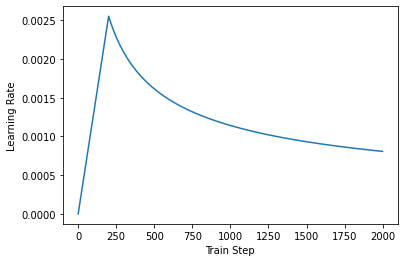

In [ ]:
temp_learning_rate_schedule = WarmupAndDecay(d_model, warmup_steps=200)

plt.plot(temp_learning_rate_schedule(tf.range(2000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
temp_learning_rate_schedule = CosineDecayWithStableRange(0.001, 0.0001, decay_start_step=500, total_steps=260*20)

temp_learning_rate_schedule(260)

<tf.Tensor: shape=(), dtype=float32, numpy=0.001>

In [ ]:
learning_rate = WarmupAndDecay(d_model, warmup_steps=200)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
last_layer_dimension = 1
if last_layer_dimension == 1:
  loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
else:
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
train_accuracy = tf.keras.metrics.BinaryAccuracy()
val_accuracy = tf.keras.metrics.BinaryAccuracy()

## Save Model and config

d_model = 768
dff = 1536
num_heads = 8
dropout_rate = 0.1
d_dense1 = 128
d_dense2 = 32
pe_input = 10000

EPOCHS = 10

In [ ]:
config = {
    'batch_size': BATCH_SIZE,
    'dataset_size': 7742+2654,
    'train_ratio': train_set_ratio,
    'val_ratio': val_set_ratio,
    'test_ratio': 0.1,
    'num_layers': num_layers,
    'd_model': d_model,
    'dff': dff,
    'num_heads': num_heads,
    'dropout_rate': dropout_rate,
    'dense_layer_1_nodes': d_dense1,
    'positional_encoding_length': pe_input,
    'epochs': 20,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'loss_fn': 'focal_loss',
    'avg_pooling': True,
    'reduction_dense_layer': False
}

In [ ]:
import json

In [ ]:
config_path = '/content/config.json'

In [ ]:
with open(config_path, 'w') as json_f:
  json.dump(config, json_f)

In [ ]:
drive_path = '/content/drive/Shareddrives/SigmaLaw-WPP/win_pred_model/transformer_encoder/D2022_04_03_T12_20'

In [ ]:
!cp -r {ckpt_folder} {drive_path}

In [ ]:
!cp {config_path} {drive_path}

## Training & Managing Checkpoints

In [ ]:
classifier = Classifier(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, pe_input=10000,
    d_dense1=d_dense1, d_dense2=d_dense2
)

In [ ]:
checkpoint_path = "./checkpoints"
checkpoint_interval = 1

In [ ]:
if os.path.exists(checkpoint_path):
  %rm -rf {checkpoint_path}

In [ ]:
ckpt = tf.train.Checkpoint(classifier=classifier, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster execution.
# The function specializes to the precise shape of the argument tensors.
# To avoid re-tracing due to the variable sequence lengths or variable batch sizes (the last batch is smaller),
# use input_signature to specify more generic shapes.

train_step_signature = [
  tf.TensorSpec(shape=(None, seq_len, d_model), dtype=tf.float32),
  tf.TensorSpec(shape=(None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(input_batch, label_batch):
  """
  input_batch: shape=(batch_size, seq_len, embed_dim) | dtype=tf.float32
  label_batch: shape=(batch_size) | dtype=tf.int64
  """
  enc_padding_mask = mask_sentence_embedding_sequence(input_batch)

  with tf.GradientTape() as tape:
    predictions = classifier(input_batch, training=True, enc_padding_mask=enc_padding_mask)

    loss = loss_fn(label_batch, predictions)

  # print(loss)
  gradients = tape.gradient(loss, classifier.trainable_variables)
  # print(gradients)
  # print([var.name for var in tape.watched_variables()])
  # print("running optimizer...")
  optimizer.apply_gradients(zip(gradients, classifier.trainable_variables))

  # loss_fn.update_state(loss)
  train_accuracy.update_state(label_batch, predictions)
  return loss

In [ ]:
val_step_signature = [
  tf.TensorSpec(shape=(None, seq_len, d_model), dtype=tf.float32),
  tf.TensorSpec(shape=(None), dtype=tf.int32),
]

@tf.function(input_signature=val_step_signature)
def test_step(input_batch, label_batch):
  enc_padding_mask = mask_sentence_embedding_sequence(input_batch)
  predictions = classifier(input_batch, training=False, enc_padding_mask=enc_padding_mask)
  loss = loss_fn(label_batch, predictions)
  # loss_fn.update_state(loss)
  val_accuracy.update_state(label_batch, predictions)
  return loss

In [ ]:
len(train_ds)

89

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  # loss_fn.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (input_batch, label_batch)) in enumerate(train_ds):
    train_loss = train_step(input_batch, label_batch)

    if batch % 20 == 0:
      print(f'Epoch: {epoch + 1} | Batch: {batch} | Accuracy: {train_accuracy.result():.4f} | Loss: {train_loss:.4f}')  

  print(f'Epoch: {epoch + 1} | Accuracy: {train_accuracy.result():.4f} | Loss: {train_loss:.4f} | Time: {(time.time() - start):.2f}s')

  # Run a validation loop at the end of each epoch.
  # loss_fn.reset_states()
  val_start = time.time()
  val_loss = 0
  for x_batch_val, y_batch_val in val_ds:
    val_loss += test_step(x_batch_val, y_batch_val)
  val_loss = val_loss / len(val_ds)

  print(f"Validation Accuracy: {val_accuracy.result():.4f} | Loss: {val_loss:.4f} | Time: {(time.time() - val_start):.2f}s")
  val_accuracy.reset_states()

  if (epoch + 1) % checkpoint_interval == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Checkpoint created at {ckpt_save_path} for epoch {epoch+1}')
  print("="*20)


Epoch: 1 | Batch: 0 | Accuracy: 0.0000 | Loss: 1.2757
Epoch: 1 | Batch: 20 | Accuracy: 0.0000 | Loss: 1.7989
Epoch: 1 | Batch: 40 | Accuracy: 0.0000 | Loss: 0.8350
Epoch: 1 | Batch: 60 | Accuracy: 0.0000 | Loss: 0.7453
Epoch: 1 | Batch: 80 | Accuracy: 0.0000 | Loss: 0.7262
Epoch: 1 | Accuracy: 0.0000 | Loss: 0.7522 | Time: 48.40s
Validation Accuracy: 0.0000 | Loss: 0.7861 | Time: 3.57s
Checkpoint created at ./checkpoints/ckpt-1 for epoch 1
Epoch: 2 | Batch: 0 | Accuracy: 0.0000 | Loss: 0.8551
Epoch: 2 | Batch: 20 | Accuracy: 0.0000 | Loss: 0.6802
Epoch: 2 | Batch: 40 | Accuracy: 0.0000 | Loss: 0.6233
Epoch: 2 | Batch: 60 | Accuracy: 0.0000 | Loss: 0.8667
Epoch: 2 | Batch: 80 | Accuracy: 0.0000 | Loss: 0.7098
Epoch: 2 | Accuracy: 0.0000 | Loss: 0.6869 | Time: 39.57s
Validation Accuracy: 0.0000 | Loss: 0.6896 | Time: 1.96s
Checkpoint created at ./checkpoints/ckpt-2 for epoch 2
Epoch: 3 | Batch: 0 | Accuracy: 0.0000 | Loss: 0.7015
Epoch: 3 | Batch: 20 | Accuracy: 0.0000 | Loss: 0.6630
Epo

In [ ]:
classifier.summary()

Model: "classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  18908160  
                                                                 
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_51 (Dense)            multiple                  98432     
                                                                 
 dense_52 (Dense)            multiple                  4128      
                                                                 
 dense_53 (Dense)            multiple                  33        
                                                                 
Total params: 19,010,753
Trainable params: 19,010,753
Non-trainable params: 0
__________________________________________

---

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  # loss_fn.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (input_batch, label_batch)) in enumerate(train_ds):
    train_loss = train_step(input_batch, label_batch)

    if batch % 20 == 0:
      print(f'Epoch: {epoch + 1} | Batch: {batch} | Accuracy: {train_accuracy.result():.4f} | Loss: {train_loss:.4f}')  

  print(f'Epoch: {epoch + 1} | Accuracy: {train_accuracy.result():.4f} | Loss: {train_loss:.4f} | Time: {(time.time() - start):.2f}s')

  # Run a validation loop at the end of each epoch.
  # loss_fn.reset_states()
  val_start = time.time()
  val_loss = 0
  for x_batch_val, y_batch_val in val_ds:
    val_loss += test_step(x_batch_val, y_batch_val)
  val_loss = val_loss / len(val_ds)

  print(f"Validation Accuracy: {val_accuracy.result():.4f} | Loss: {val_loss:.4f} | Time: {(time.time() - val_start):.2f}s")
  val_accuracy.reset_states()

  if (epoch + 1) % checkpoint_interval == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Checkpoint created at {ckpt_save_path} for epoch {epoch+1}')
  print("="*20)


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
running optimizer...
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
running optimizer...
Epoch: 1 | Batch: 0 | Accuracy: 0.0000 | Loss: 2.4391
Epoch: 1 | Batch: 20 | Accuracy: 0.4777 | Loss: 9.5308
Epoch: 1 | Batch: 40 | Accuracy: 0.4817 | Loss: 4.7654
Epoch: 1 | Batch: 60 | Accuracy: 0.4800 | Loss: 8.1012
Epoch: 1 | Batch: 80 | Accuracy: 0.4911 | Loss: 5.2419
Epoch: 1 | Accuracy: 0.4940 | Loss: 8.1012 | Time: 42.48s
Validation Accuracy: 0.5000 | Loss: 7.0687 | Time: 3.02s
Checkpoint created at ./checkpoints/ckpt-1 for epoch 1
Epoch: 2 | Batch: 0 | Accuracy: 0.5625 | Loss: 6.6715
Epoch: 2 | Batch: 20 | Accuracy: 0.5060 | Loss: 9.5308
Epoch: 2 | Batch: 40 | Accuracy: 0.4939 | Loss: 6.6715
Epoch: 2 | Batch: 60 | Accuracy: 0.4944 | Loss: 7.6246
Epoch: 2 | Batch: 80 | Accuracy: 0.4973 | Loss: 7.1481
Epoch: 2 | Accuracy: 0.5000 | Loss: 9.5308 | Time: 28.51s
Validation Accuracy: 0.5000 

In [ ]:
len(classifier.trainable_variables)

70

In [ ]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  12612608  
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  98432     
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 dense_25 (Dense)            multiple                  4128      
                                                        